# 1.1 Birth Rates

The data on US births, provided by the CDC is in `data/births.csv`.

Reproduce the following plot of births by gender over time given the data:

![](births_gender.png)

Note the `1e6` on the y axis for scale

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from  math import cos, pi
import seaborn as sns
import pandas as pd         
from pandas_datareader import data
import datetime as dt
import gzip 
import seaborn as sns
import json

%matplotlib inline

In [2]:
df = pd.read_csv('data/births.csv')


In [37]:
def plot_births(df):
    table = df.pivot_table(index='year',
                           columns='gender',
                           values='births',
                           aggfunc=np.sum)
    table.plot(title="Total births by gender over years", 
                color=['b', 'darkorange'],
                ylabel='Total Births per year'
    )


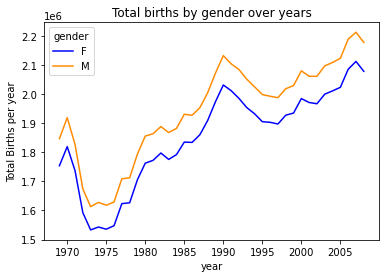

In [4]:
plot_births(df)

<AxesSubplot:xlabel='year'>

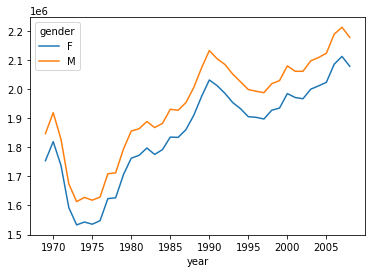

In [5]:
df.groupby(['year','gender']).births.sum().unstack().plot()

# 1.2 Births anomalies

This was analyzed by beloved statistician Andrew Gelman [here](http://andrewgelman.com/2012/06/14/cool-ass-signal-processing-using-gaussian-processes/), leading to this plot:

![](births_gp100.png)

Explain all three plots in Gelman's figure. 

**1.2:** What is the periodic component? What is the residual? Use your research skills to learn then explain it (in english).

In [ ]:
# ref 1 http://chmullig.com/2012/06/births-by-day-of-year/
# ref 2 https://www.mathworks.com/help/signal/ug/significance-testing-for-periodic-component.html
# ref 3 https://www.toppr.com/guides/business-mathematics-and-statistics/time-series-analysis/components-of-time-series/
# ref 4 https://machinelearningmastery.com/visualize-time-series-residual-forecast-errors-with-python/

# The periodic component:
    # When observing and studying a variable over a period time, there are trends that can repeat over cyclical periods or seasons.

# The residual component:
    # "Forecast errors on time series regression problems are called residuals or residual errors" [ref 4]

# 1.3 Holiday Anomalies Plot

Reproduce *as best you can* the first of the 3 figures from Andrew Gelman's blog post (your plot may have small differences)

**1.3.1:** Reproduce the births line in a plot. Hint: Make the x axis a `pd.datetime` object

**1.3.2:** Reproduce the `smoothed` line. Hint: use a rolling window average

**1.3.3:** Reproduce the entire figure with the mean line as a horizontal. You can make the y axis total births instead of a % deviation from mean axis (they'll look the same anyway)

In [2]:
df = pd.read_csv('data/births.csv')


In [3]:
#clean useless data
df = df.dropna()
df = df.drop(df.index[df.day > 31])
df = df.drop(df.index[df.month.isin([4,6,9,11]) & df.day > 30])
df = df.drop(df.index[df.month.isin([1]) & df.day > 28])

In [4]:

df['n'] = df.births / df.births.mean() * 100
df['avg'] = 100

In [5]:
 df['date'] = pd.to_datetime(df[['year','month','day']],errors='coerce')
 df['dday'] = df.date.dt.dayofyear

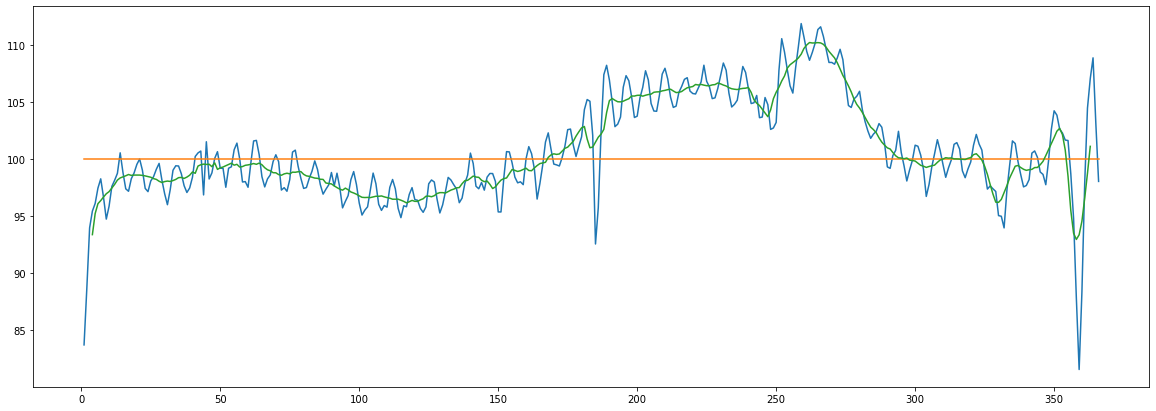

In [6]:
fig, ax = plt.subplots(figsize=(20, 7))

ax.plot(df.groupby(["dday"]).agg({'n':'mean'}))
ax.plot(df.groupby(["dday"]).agg({'avg':'mean'}))
ax.plot((df.groupby(["dday"]).agg({'n':'mean'})).rolling(7, center=True).mean()) # got help from J

In [7]:
#df = df.groupby(['date']).sum()
#smoothed = gaussian_filter1d(df.births, sigma=10)
#rolling = df.rolling(7,center=True)

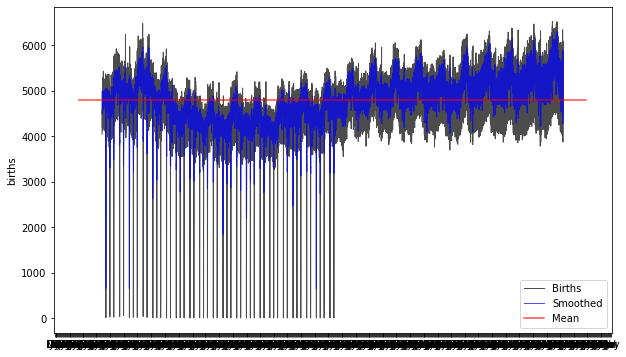

In [12]:
#fig, ax = plt.subplots(figsize=(10, 6))
#ax.plot(df.index,df.births,lw=1,alpha=0.7)

# ax.hlines(y=df.births.mean(), xmin = df.index.min(), xmax= df.index.max(), label='Mean', colors='r')
# plt.plot(df.index, df.births, lw=1, label='Births', color='black')
# #plt.plot(df.index, ysmoothed, label='Smoothed', color='b')

# ax.legend()
# plt.show()

In [97]:

#df.day = df.day.fillna(1)
#df.day = df.day.replace(99,1)
#df.loc['month']=
# df['date'] = pd.to_datetime(df[['year','month','day']],errors='coerce')
#df
#rolling = df.rolling(window=10).mean()
#rolling = df.rolling(7,center=True)
#custom = df.groupby(['month', 'day']).agg({'births': ['mean']}).reset_index()
#custom

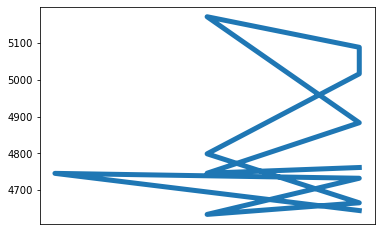

In [104]:
#fig, ax = plt.subplots(1,1) #(figsize=(14,10))#
##ax.plot_date(pd.to_datetime(df['month']),df['births'],sum(),alpha=0.25,lw=0)

#ax.plot(pd.to_datetime(df.groupby('month')['day'].max()), df.groupby('month')['births'].mean(), '-', lw = 5)
##ax.plot(df.groupby('month')['month'].max(), df.groupby('month')['births'].mean(), '-', lw = 5)

##axes.plot(custom.,custom.birth)
##custom.columnsQW

# 2. Recipe Database

### 2.1 

Load the JSON recipe database we saw in lecture 4.

How many of the recipes are for breakfast food? Hint: The `description` would contain the work "breakfast"

In [ ]:
with gzip.open('data/recipe.json.gz','r') as f:
    data = (line.strip().decode() for line in f)
    data_json = f"[{','.join(data)}]"
recipes = pd.read_json(data_json)

In [28]:
recipes = pd.read_json('data/recipe.json', lines=True)

In [29]:

recipes.description.str.lower().str.contains("breakfast").sum() 


3524

### 2.2 A simple recipe recommender

Let's build a recipe recommender: given a list of basic ingredients, find a recipe that uses all those ingredients.

Here is the list of ingredients that can be asked for:

```
['salt', 'pepper', 'oregano', 'sage', 'parsley',
 'rosemary', 'tarragon', 'thyme', 'paprika', 'cumin']
```

**Hint:** Build a new column for each of the ingredients that indicates whether that ingredient is in the recipe.

**example:**
```
recommend_ingredients(["parsley", "paprika", "tarragon"], df)

result: 
# The rows where these 3 ingredients are in the recipe
[2069, 74964, 93768, 113926, 137686, 140530, 158475, 158486, 163175, 165243]
```

In [81]:
def recommend_ingredients(ing, df):
    all_ing = ['salt', 'pepper', 'oregano', 'sage', 'parsley',
 'rosemary', 'tarragon', 'thyme', 'paprika', 'cumin']
    for I in all_ing:
        recipes[I] = recipes.ingredients.str.lower().str.contains(I)
    df=recipes    
    for ing in ing: 
         df = df.loc[df[ing] == True]
    return df.index

In [82]:
recommend_ingredients(["parsley", "paprika", "tarragon"], recipes)

Int64Index([  2069,  74964,  93768, 113926, 137686, 140530, 158475, 158486,
            162896, 163175, 165243, 171774],
           dtype='int64')

# 3. Movies!

Recall the [Movies Dataset](https://www.kaggle.com/rounakbanik/the-movies-dataset) from lecture 4. It's made up of several tables which we've played with in lecture 4.

The tables have common columns (`id` and `movie_id`) around which you can merge and join tables.

### 3.1 best director

Your task is to find **The best director** in terms of average ratings of his movies. This can be from the `ratings` or `ratings_small` table, or simply the vote average in the `metadata` table. The director can be found in the `cast` table.

You will have to use all of your skills to get this done, between using groupbys and merging multiple tables together

In [128]:
credits = pd.read_csv('data/credits.csv')
metadata = pd.read_csv('data/movies_metadata.csv')

In [129]:
df = pd.DataFrame()
credits['director'] = credits['crew'].str.extract("'Director', 'name': '(.*?)\',")

In [130]:

#credits.id?
#metadata.id?
credits.id =credits.id.astype(str)
metadata.id = metadata.id.astype(str)

df = pd.merge(credits, metadata, on='id')


In [131]:
avg = df.groupby(["director"]).agg({'vote_average':'mean'})

In [132]:
avg = avg.sort_values('vote_average',ascending=False,)

In [141]:
avg.reset_index()
avg.head(20)

#avg = avg.loc['vote_average' == 10]

,vote_average
director,
Steven Lewis Simpson,10.0
Nissim Dayan,10.0
Duncan McLachlan,10.0
Jane Howell,10.0
Christopher Fraser,10.0
Mehul Kumar,10.0
Helena Solberg,10.0
Bruno Irizarry,10.0
Holly L. De Ruyter,10.0


In [139]:
avg

,vote_average
director,
Steven Lewis Simpson,10.0
Nissim Dayan,10.0
Duncan McLachlan,10.0
Jane Howell,10.0
Christopher Fraser,10.0
...,...
Mark A. Reyes,0.0
Victor Duncan,0.0
Mark Altman,0.0


In [67]:
#data_transposed = zip(credits.crew[0])
#credits.crew[0]('credit_id','department','gender','id','job','name','profile_path')

In [99]:
#metadata.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [72]:
# data_transposed
# df = pd.DataFrame(data_transposed, columns=['credit_id']#,'department','gender','id','job','name','profile_path'])
# df

SyntaxError: invalid syntax (<ipython-input-72-e0d6e93651b2>, line 3)

In [64]:
#pat = r'(?P<price>\d*\.\d*)\s*x\s*(?P<size>\d*)\s*\((?P<num_orders>\d*)\)$'
#pat = r'((.*?)\',')
# credits[['credit_id','department','gender','id','job','name','profile_path']] = credits.crew.str.extract(""'(.*?)\',", expand=True)#4945
#test = credits.crew.to_numpy


In [75]:
#cast = credits.crew.str.extract()



In [83]:
#ll = list(credits.director.unique())

In [92]:
#len(ll)

17488